In [90]:
### my last attempt which had the largest score is to excluse Gender, and use median to impute missing age
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
trainData = pd.read_csv('./train.csv')
testData = pd.read_csv('./test.csv')
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [91]:
## preparing train data
family = pd.DataFrame(0, index=xrange(len(trainData)), columns=['Family'])
for ii in xrange(len(trainData)):
    if (((trainData.SibSp[ii]+trainData.Parch[ii])>0)&((trainData.SibSp[ii]+trainData.Parch[ii])<5)): 
        family.Family[ii]=1
    else:
        if ((trainData.SibSp[ii]+trainData.Parch[ii])>4):
            family.Family[ii]=2

gender = pd.DataFrame(0, index=xrange(len(trainData)), columns=['Gender'])
for ii in xrange(len(trainData)):
    if (trainData.Sex[ii]=='female'): 
        gender.Gender[ii]=1
 
new = pd.DataFrame(0, index=xrange(len(trainData)), columns=['New']) ## initialize new column
for ii in xrange(len(trainData)):
    if (trainData.Age[ii]<10):
        new.New[ii] = 2
    else:
        if (trainData.Sex[ii]=='female'): 
            new.New[ii]=1
            
embar = pd.DataFrame(0, index=xrange(len(trainData)), columns=['Embarked']) ## 0 indicates embarked C (i want the two)
### missing values get embarked C which associates with a larger fraction of survival
for ii in xrange(len(trainData)):
    if (trainData.Embarked[ii]=='S'):
        embar.Embarked[ii] = 1
    else:
        if (trainData.Embarked[ii]=='Q'): 
            embar.Embarked[ii] = 2


import re
# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Get all the titles and print how often each one appear.
titles = trainData["Name"].apply(get_title)

titles[(titles=='Capt')|(titles=='Don')|(titles=='Rev')|(titles=='Jonkheer')|(titles=='Dr')|(titles=='Mr')]=0
titles[(titles=='Major')|(titles=='Col')|(titles=='Sir')|(titles=='Master')]=1
titles[(titles=='Ms')|(titles=='Lady')|(titles=='Mme')|(titles=='Mlle')|(titles=='Countess')|(titles=='Mrs')]=2
titles[(titles=='Miss')]=3
 
### No missing values with this matrix, because the Embarked 2 missing values also fixed with C    
newDF = pd.concat([titles,family.Family,gender.Gender,trainData.Pclass,embar.Embarked,
                            trainData.Fare],axis=1)
newDF.head()

,Name,Family,Gender,Pclass,Embarked,Fare
0,0,1,0,3,1,7.2500
1,2,1,1,1,0,71.2833
2,3,0,1,3,1,7.9250
3,2,1,1,1,1,53.1000
4,0,0,0,3,1,8.0500


In [92]:
## bin the fare
binsf = [0.0,15,30,45.0,75,110,150,max(newDF.Fare)]
ticket = pd.cut(newDF.Fare,binsf,include_lowest=True)
newDF['LowerFare'] = ticket.str[1:4]
newDF['LowerFare'] = newDF['LowerFare'].str.replace(',','')
newDF['UpperFare'] = ticket.str[-4:-1]
newDF.head()

,Name,Family,Gender,Pclass,Embarked,Fare,LowerFare,UpperFare
0,0,1,0,3,1,7.2500,0,15
1,2,1,1,1,0,71.2833,45,75
2,3,0,1,3,1,7.9250,0,15
3,2,1,1,1,1,53.1000,45,75
4,0,0,0,3,1,8.0500,0,15


In [93]:
## We have to do imputation for Age
## lets see how mean or median of Age associates with different group
### I want to see how family, title and Fare relates to Age
dataWithAge = pd.concat([trainData.Age,newDF],axis=1)
dataWithAge.Age.fillna(dataWithAge.groupby(['Pclass','Family','Name']).Age.transform("median"), 
                       inplace=True)

#### bin the ages
bins = [0.1,10.0,19.0,32.0,43.0,60.0,max(trainData.Age)]
groups = [0,1,2,3,4,5]
agee = pd.cut(dataWithAge['Age'],bins,include_lowest=True)
dataWithAge['LowerAge'] = agee.str[1:3]
dataWithAge['UpperAge'] = agee.str[-3:-1]

#datF = dataWithAge.drop()
datF = pd.concat([newDF.ix[:,:'Fare'],dataWithAge.ix[:,'LowerAge':],trainData.Survived],axis=1)
datF.head()

,Name,Family,Gender,Pclass,Embarked,Fare,LowerAge,UpperAge,Survived
0,0,1,0,3,1,7.2500,19,32,0
1,2,1,1,1,0,71.2833,32,43,1
2,3,0,1,3,1,7.9250,19,32,1
3,2,1,1,1,1,53.1000,32,43,1
4,0,0,0,3,1,8.0500,32,43,0


In [94]:
from sklearn.cross_validation import train_test_split

train, test = train_test_split(datF, test_size = 0.25)
features_train = train.ix[:,:'UpperAge']
labels_train = train.Survived
features_test = test.ix[:,:'UpperAge']
labels_test = test.Survived

from sklearn import tree
clf_DT = tree.DecisionTreeClassifier(random_state=69069,max_leaf_nodes=25)
clf_DT.fit( features_train, labels_train )
pred_DT = clf_DT.predict( features_test )

from sklearn.metrics import accuracy_score
print accuracy_score(labels_test,pred_DT)

from sklearn.naive_bayes import GaussianNB
clf_NB = GaussianNB()
clf_NB.fit( features_train, labels_train )
pred_NB = clf_NB.predict( features_test )
print accuracy_score(labels_test,pred_NB)

from sklearn.svm import SVC
#clf = SVC(kernel='linear')
clf_svm = SVC(kernel='rbf',C=1.0)   ### 0.990898
clf_svm.fit(features_train, labels_train)
pred_svm = clf_svm.predict(features_test)
print accuracy_score(labels_test,pred_svm)

0.816143497758
0.775784753363
0.72197309417


0.835329341317
0.825112107623
Feature ranking:
1. feature 0 (0.497146)
2. feature 5 (0.277431)
3. feature 3 (0.129084)
4. feature 6 (0.034651)
5. feature 7 (0.030352)
6. feature 4 (0.020271)
7. feature 1 (0.007667)
8. feature 2 (0.003398)


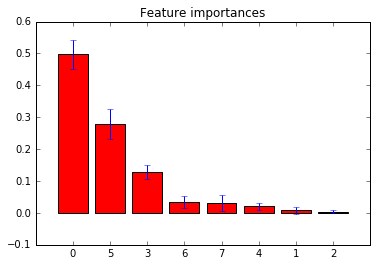

In [95]:
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(max_features=None,random_state=5,n_estimators=10,
                                min_samples_leaf=5,oob_score=True)
clf_RF.fit( features_train,labels_train )
pred_RF = clf_RF.predict(features_test)
#print accuracy_score(labels_train,clf_RF.predict(features_train))
print clf_RF.oob_score_
print accuracy_score(labels_test,pred_RF)

importances = clf_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_RF.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
X = features_train
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
from sklearn.metrics import roc_auc_score

In [96]:
## preparing test datadata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAXkAAAEKCAYAAAD3tSVSAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAGTlJREFUeJzt3X+8XHV95/HXO0mDAoutsiYQSmjLIkK1ijVkV12GpsoNKqHtrgZdULut6T5MdX30R9B2m2sfbdc8tj+wD9Z2U2MWf9RY8AexqMSujJVWJCD4Y7khUSTkhwQpWOTH1hje+8c5N5lc7p37Y86dOffk/Xw85pFzZr5zvp87ufc9Zz7nzIxsExERzTRv0AVERMTsSchHRDRYQj4iosES8hERDZaQj4hosIR8RESDJeTjmCXpLyT9zqDriJhNynnyMV2S7gWeDfwQEGDgLNv397DNC4AP2f7xSoqcYyRtBvbY/r1B1xLNsmDQBcScZOCVtm+qcJujTxYzu7M03/ahCuvpG0l5RR2zJr9cMVMa90ppuaR/kPSwpDvKPfTR294o6S5Jj0j6pqQ3l9cfD3waOFXS98vbF0vaLOn3O+5/gaQ9HevflvTbkr4KPCppnqRTJF0n6QFJ35L06xP+AB3bH922pN+SdEDSPkmrJK2UdLekByW9o+O+6yVdK2lLWe9tkp7fcfvZkm4qH4evS3r1mHnfK+kGSd8H/jPweuC3y21dX45bVz5Oj0j6hqRLO7bxBklflPQ/JD1U/qxDHbf/mKT3lz/HP0n6eMdtryr/bx6WdLOk53Xctk7S3nLOEUkXTvT4xRxhO5dcpnUBvg383DjXnwo8CFxUrq8o159Vrq8EziiXXwY8BrygXL8AuG/M9jYDv9+xftSYso6vlPMeR/HEcxvwO8B84Azgm8DLJ/g5Dm+/3PbBjvv+CvAA8CHgeOAc4HFgaTl+PfAvwC+U438DuKdcXgDsAtaVyxcCjwD/pmPeh4Hl5fpxY3/W8vpfAhaVy/8ReLRj/Q3l/L9c/ty/BuzruO8NwEeAk8qaXlZe/0LgAPCz5f0uLx/HHwHOAu7rmON04CcG/fuWS2+X7MnHTH2y3IN8qGMv8T8BN9i+EcD2/6EI3YvL9c/Yvrdc/iKwjSLse/Ee2/tt/wvwYuBk239o+1A51/uA1VPc1g+AP3LR9tkCnAxcZftx23cBdwE/0zH+dtufKMf/KUVYLy8vJ9jeYPuHLtpafwtc1nHf623fAlDW/hS2P2b7QLl8LcUTx7KOIbttv9+2gWuAUyQ9W9Ji4CJgje1Hysfii+V9fhX4S9u3ufBBiieL5cAhYCHw05IW2L7P9ren+NhFTaUnHzO1yk/tyS8FXtPRmhDF79jnASStBH6PYo9xHvB04Gs91rF3zPxLJD3UMf884O+nuK1/KgMT4Iny3wc6bn8COLFj/XDryLYl7aN4VaHO20q7gSXj3Xcikq4A3k7xigTgBIonnlGHD3TbfkISZX3PAh6y/cg4m10KXNHRxhLFXvyptr8o6b8Cw8A5km4EfsP2dyarNeorIR8zNV5Pfg/wAdtrnjJYWghcR7G3f73tJyV9omM74x10fYyiVTLqlHHGdN5vD3CP7edMof4qHD4TSEXCngbsp/iZTh8z9nTg7o71sT/vUeuSTgc2Ahfa/lJ53R1McCxkjD3AMyWdNE7Q7wH+0PZ/H++OtrcAWySdWM7/borWUMxRaddElT4EvFrSK8qDoE8rD2ieStEGWAg8WAb8SuAVHfc9ADxL0kkd190JXFweRFwMvG2S+W8Fvl8ejH2apPmSzpX0s9X9iEd5kaRLJc2n2OP+f8AtwJeBx8o6FkhqAa+i6JFP5ADwkx3rJwBPAg+Wj+WbgJ+eSlEuTmX9DPBeST9a1jDaFvsr4NckLQOQdIKki8t/z5J0YfmE/AOKVy5PTumRiNpKyMdMjHuqo+29wCrgncB3KVoUvwnMs/0o8Fbg2rKdshq4vuO+d1OE4D1ln38x8EGKds69wGcp+uQT1mH7SYowfQHFwcQHKELtJGam6952Wf9rKQ6ivh74hbL/fRB4NcWxiAeBq4HLbe+aYDsAm4BzR49x2B6h6PPfQtGWORe4eRr1Xk7xPoYdFE8gbwOwfTtFX/7q8v9hJ0f21I+j2HP/LsUrkn8NvIOY0yp5M1R56tZVFE8am2xvGHP7b1L8EZii//dcigNk3+t58ogBkLQe+CnbVwy6lohuet6TV/FGjqspjuafC1wm6ezOMbb/2PYLbZ9HsWfQTsBHRMy+Kto1y4BdtneXL1O3ULxkn8hldO9NRkRERao4u2YJR58Otpejz+U9TNLTgSHgLRXMGzEwtt816BoipqLfB15fDdycVk1ERH9UsSe/j6PPCT6tvG48q5mkVSMpH4sZETFNtsd9D0UVe/LbgTMlLS3Pr10NbB07SNIzKD4f5Pqxt4016M96WL9+/cBrqEsdqaFeddShhrrUUYca6lJHNz3vyds+JGktxeeQjJ5COSJpTXGzN5ZDLwVutP3ERNuKiIhqVfKxBrY/CzxnzHX/a8z6NRQfohQREX2Sd7yOo9VqDboEoB51pIYj6lBHHWqAetRRhxqgPnVMpHZf/yfJdaspIqLOJOFZPPAaERE1lZCPiGiwhHxERIMl5CMiGiwhHxHRYAn5iIgGS8hHRDRYvsi71G4Xl9Hl0fc3tFpHliMi5pq8GWrcGqBmD0tExITyZqiIiGNUQj4iosES8hERDZaQj4hosIR8RESDJeQjIhosIR8R0WAJ+YiIBqsk5CUNSdohaaekdROMaUm6Q9I3JN1UxbwREdFdz+94lTQP2AmsAPYD24HVtnd0jHkG8I/AK2zvk3Sy7Qcn2F7e8RoRMQ2z/Y7XZcAu27ttHwS2AKvGjHkd8DHb+wAmCviIiKhWFSG/BNjTsb63vK7TWcAzJd0kabukyyuYNyIiJtGvT6FcAJwH/BxwAvAlSV+y/c3xBg8PDx9ebrVatPIxkBERh7XbbdqjH5s7iSp68suBYdtD5fqVgG1v6BizDnia7XeV6+8DPmP7Y+NsLz35iIhpmO2e/HbgTElLJS0EVgNbx4y5HnippPmSjgfOB0YqmDsiIrrouV1j+5CktcA2iieNTbZHJK0pbvZG2zsk3Qh8DTgEbLR9V69zR0REd/nSkHFrSLsmIuaOfGlIRMQxKiEfEdFgCfmIiAZLyEdENFhCPiKiwRLyERENlpCPiGiwhHxERIMl5CMiGiwhHxHRYAn5iIgGS8hHRDRYQj4iosES8hERDZaQj4hosIR8RESDJeQjIhosIR8R0WAJ+YiIBqsk5CUNSdohaaekdePcfoGk70n6Snn53SrmjYiI7hb0ugFJ84CrgRXAfmC7pOtt7xgz9O9tX9LrfBERMXVV7MkvA3bZ3m37ILAFWDXOuHG/STwiImZPFSG/BNjTsb63vG6sfyvpTkk3SDqngnkjImISPbdrpuh24HTbj0taCXwSOGuiwcPDw4eXW60WrVZrtuuLiJgz2u027XZ7SmNlu6fJJC0Hhm0PletXAra9oct9vg28yPZD49zmXmvqlQQDLiEiYsokYXvclngV7ZrtwJmSlkpaCKwGto4pYFHH8jKKJ5enBHxERFSr53aN7UOS1gLbKJ40NtkekbSmuNkbgf8g6b8AB4EngNf2Om9EREyu53ZN1dKuiYiYntlu10RERE0l5CMiGiwhHxHRYAn5iIgGS8hHRDRYQj4iosES8hERDZaQj4hosIR8RESDJeQjIhosIR8R0WAJ+YiIBkvIR0Q0WEI+IqLBEvIREQ2WkI+IaLCEfEREgyXkIyIaLCEfEdFglYS8pCFJOyTtlLSuy7gXSzoo6RermDciIrrrOeQlzQOuBi4CzgUuk3T2BOPeDdzY65wRETE1VezJLwN22d5t+yCwBVg1zrhfB64DHqhgzoiImIIqQn4JsKdjfW953WGSTgUutf0XgCqYc8rOWLwYSdO6lDVP63LG4sX9/LEiIqZkQZ/muQro7NV3Dfrh4eHDy61Wi1arNeOJdx84gKd5H8H073PgwDTvERExM+12m3a7PaWxsqcbZ2M2IC0Hhm0PletXAra9oWPMPaOLwMnAY8CbbW8dZ3vutaYx25tByBtP8wWHgCrrjoiYKknYHje0qgj5+cDdwArgO8CtwGW2RyYYvxn4lO2PT3B7Qj4iYhq6hXzP7RrbhyStBbZR9Pg32R6RtKa42RvH3qXXOWN2tdvFZXR5tFvWah1Zjoi5oec9+aplT75eJGjgjxXRKN325POO14iIBkvIR0Q0WEI+IqLBEvIREQ2WkI+IaLCEfEREgyXkIyIaLCEfEdFgCfmIiAZLyEdENFhCPiKiwRLyERENlpCPiGiwhHxERIMl5CMiGiwhHxHRYAn5iIgGS8hHRDRYQj4iosEqCXlJQ5J2SNopad04t18i6auS7pB0q6SXVDFvRER01/MXeUuaB+wEVgD7ge3Aats7OsYcb/vxcvl5wN/Yfu4E28sXeddIvsg7ov5m+4u8lwG7bO+2fRDYAqzqHDAa8KUTgScrmDciIiZRRcgvAfZ0rO8trzuKpEsljQCfAn65gnkjImISC/o1ke1PAp+U9FLgD4CXTzR2eHj48HKr1aLVas12eRERc0a73abdbk9pbBU9+eXAsO2hcv1KwLY3dLnPt4AX235onNvSk6+R9OQj6m+2e/LbgTMlLZW0EFgNbB1TwE91LJ8HLBwv4CMiolo9t2tsH5K0FthG8aSxyfaIpDXFzd4I/JKkK4AfAE8Ar+l13oiImFzP7ZqqpV1TL2nXRNTfbLdrIiKiphLyERENlpCPiGiwhHxERIMl5CMiGiwhHxHRYAn5iIgGS8hHRDRYQj4iosES8hERDZaQj4hosIR8RESDJeQjIhosIR8R0WAJ+YiIBkvIR0Q0WEI+IqLBEvIREQ2WkI+IaLBKQl7SkKQdknZKWjfO7a+T9NXycrOk51Uxb0REdNdzyEuaB1wNXAScC1wm6ewxw+4B/r3tnwH+APirXueNiIjJLahgG8uAXbZ3A0jaAqwCdowOsH1Lx/hbgCUVzNtI7XZxGV1utYrlVuvIckTEVFUR8kuAPR3reymCfyK/AnymgnkbqTPMpSOBHxExE1WE/JRJuhB4E/DSbuOGh4cPL7daLVrZhY2IOKzdbtOe4h6gbPc0maTlwLDtoXL9SsC2N4wZ93zgY8CQ7W912Z57rWnM9pju1oQxmuZ9oMq6odiTr3iTc7KGiOhOErbHDa0qzq7ZDpwpaamkhcBqYOuYAk6nCPjLuwV8RERUq+d2je1DktYC2yieNDbZHpG0prjZG4H/BjwTeK8kAQdtd+vbR0REBXpu11Qt7ZqObdagVVKHGiKiu9lu10RERE0l5CMiGiwhHxHRYAn5iIgGS8j3wRmLFyNp2hdg2vc5Y/HiAf+0EVEnObtmvPtUfHbNTGqYjTpmImfXRNRft7NrEvKlNhfQplUut2jRBqBFmxZfmHweEvIRMRgJ+cq21mUeEvIRMRg5Tz6AmR0bgBwXiJjLsidf1TzUf0++DscnIqJ62ZOPiDhGJeQjIhosIR8R0WAJ+YiIBkvIR0Q0WM6uqWoeqjmrpW5vysrZNRH1lzdDVba1LvNQ/SmUdagjIR9RfzmFMiLiGJWQj4hosJ6/yBtA0hBwFUe+yHvDmNufA2wGzgPeaftPq5g3mqvdLi6jy61WsdxqHVmOiMn13JOXNA/YCawA9gPbgdW2d3SMORlYClwKPNwt5NOTr1cddejJ50PSIrqb7Z78MmCX7d22DwJbgFWdA2w/aPt24IcVzBcREVNURcgvAfZ0rO8tr4uIiAGrpCdfteHh4cPLrVaLVpqwERGHtdtt2qMHrSZRRU9+OTBse6hcvxLw2IOv5W3rge+nJz936khPPqL+Zrsnvx04U9JSSQuB1cDWbvVUMGdERExBz+0a24ckrQW2ceQUyhFJa4qbvVHSIuA24F8BT0p6G3CO7Ud7nT8iIiaWjzWoah7SrplKDTORdk1Ed/lYg4iIY1RCPvqqX18mni8UjyikXVPVPKRdU6caJqsjokm6tWtqeZ58RF3kM3RirsuefFXzkD35OtUwWR0zMagDwHmiicnkS0Mq21qXeUjI16mGyeqYiTqc5TPIGvJkU18J+cq21mUeEvJ1qmGyOmbiWA/5OtYRhZxCGRFxjMqB14iYM9Iymr60a6qah7Rr6lTDZHWcsXgxuw8cmOYWzXQ/emnpokXce//9A61hsjpmog7tmjrUUBfpyVe2tS7zkJCvUw11qaMONUxWx0zUIWDrUENd5Dz5iIgKzaW2Ufbkq5qH7MlXWUObC2jTKpdbtGgD0KJNiy/0rY6jt9fMPfk6tK5moi578nWoI+2ayrbWZR4S8rNVw0w18bFoausqxyd6rSEhP+sSbLNXw0w18bFoasjX5bGYiYT8NCXk61VHHf6YZ6opj0VaV9XVMFkdM5GQn6aEfL3qqMMf80zVIWCb9Fgcvb3B/17k+MQRCfnKttZlHvLHPFs1zFQd6qhDDbNRRx1+L5raupqJWQ95SUPAVRz5jtcN44z5c2Al8BjwRtt3TrCthHyN6qjDH/NM1aGOOtQwG3WkddW5vYaHvKR5wE5gBbAf2A6str2jY8xKYK3tV0o6H3iP7eUTbC8hX6M6EvJzv4aq6kjraqLtNT/klwPrba8s168E3Lk3L+kvgZtsf7RcHwFatp/S/ErI16uOhPzcr6EuddShhtmoo+4hX8U7XpcAezrW9wLLJhmzr7xuukc4IiIGrvNVzQW0GWY9ML22Ub/kYw0iIqapxRc6wvxdA61lMlWE/D7g9I7108rrxo758UnGHDY8PHx4udVq0erhwyCWLlqEpn1K1MzmGXQNs1XHdM9faPJjMRdrqEsddaihLnV0q2Eq2u027dEPz5lEFT35+cDdFAdevwPcClxme6RjzMXAW8oDr8uBq/p14DV6U4c3ekREd7Pak7d9SNJaYBtHTqEckbSmuNkbbX9a0sWSvklxCuWbep03IiIm1/g3Q0VvsicfUX/5jteIiGNUQj4iosES8hERDZaQj4hosIR8RESDJeQjIhosIR8R0WAJ+YiIBkvIR0Q0WEI+IqLBEvIREQ2WkI+IaLCEfEREgyXkIyIaLCEfEdFgCfmIiAZLyEdENFhCPiKiwfL1f/EU7XZxGV1utYrlVuvIckTUR7ev/+sp5CX9GPBRYClwL/Aa2/88zrhNwKuAA7afP8k2E/IREdMwm9/xeiXwd7afA3weeMcE4zYDF/U4V9+0R3djB6wOdaSGI+pQRx1qgHrUUYcaoD51TKTXkF8FXFMuXwNcOt4g2zcDD/c4V9/U5T+tDnWkhiPqUEcdaoB61FGHGqA+dUyk15B/tu0DALbvB57de0kREVGVBZMNkPQ5YFHnVYCB3x1neJrpERE10uuB1xGgZfuApMXATbafO8HYpcCnpnLgdcYFRUQcoyY68DrpnvwktgJvBDYAbwCu7zJW5aWriQqNiIjp67UnvwF4uaS7gRXAuwEknSLpb0cHSfpr4B+BsyTdJ+lNPc4bERFTULs3Q0VERHXysQYdJA1J2iFpp6R1A6rhOElflnSHpK9LWj+gOk6T9HlJ/7es460DqGGTpAOSvtbvucep5RmSrpU0Uj4m5w+ojnmSviJp6yDmL2u4V9JXy9/RWwcw/1nl3F8p//3nAf1+vl3SNyR9TdKHJS3sdw1TkT35kqR5wE6KttN+YDuw2vaOAdRyvO3HJc0H/gF4q+2+/jGVB9IX275T0onA7cCqfj4ekl4KPAp8YLID9n2o5X8DX7C9WdIC4HjbjwygjrcDLwJOsn1Jv+cva7gHeJHtgb/3pfy73Qucb3tPH+c9FbgZONv2DyR9FLjB9gf6VcNUZU/+iGXALtu7bR8EtlC82avvbD9eLh5HcXC878/Etu+3fWe5/CgwAizpcw21eBOdpJOAl9neDGD7hwMK+NOAi4H39XvusaVQn+z4eeBb/Qz4DvOBE0af9Cl2DmunLv9RdbAE6PxF2UufQ21U+ZL8DuB+4HO2tw+ijo56zgBeAHx5kHUM0E8AD0raXLYINkp6+gDq+DPgtxj8+1EMfE7Sdkm/OuBaXgt8pN+T2t4P/AlwH7AP+J7tv+t3HVORkK8h20/afiFwGnC+pHMGVUvZqrkOeFu5R38sWgCcB/xP2+cBj1N8blPfSHolxQf83ckUT0eeRS8pH4eLgbeUbbW+k/QjwCXAtQOY+0cpXukvBU4FTpT0un7XMRUJ+SP2Aad3rJ9WXjcwZUvgJmBoEPOXL0OvAz5ou9t7IJpuL7DH9m3l+nUUod9PLwEuKfvhHwEulDSQ/q/t75T/fhf4BEWrcxBWAreXdfTbzwP32H7I9iHg48C/G0Adk0rIH7EdOFPS0vIo+WqKN3v1laSTJT2jXH468HKg7wd/S+8H7rL9ngHND4Pfa6X8fKY9ks4qr1oB3NXnGt5p+3TbP0nxu/l521f0swYoTgooX90h6QTgFcA3+l1H6TIG0Kop3Qcsl/Q0SaL4nRgZUC1d9fqO18awfUjSWmAbxZPfJtuD+E87BbimPGtgHvBR25/udxGSXgK8Hvh6eXzAwDttf7aPNfw10AKeJek+YP3owc8BeCvw4bJFcA9wrL6hbxHwifLjRxYAH7a9rd9FSDqeYm/6zf2eG8D2rZKuA+4ADpb/bhxELZPJKZQREQ2Wdk1ERIMl5CMiGiwhHxHRYAn5iIgGS8hHRDRYQj4iosES8hERDZaQj4hosP8PAJDImbQK3a4AAAAASUVORK5CYII=
familyPR = pd.DataFrame(0, index=xrange(len(testData)), columns=['Family'])
for ii in xrange(len(testData)):
    if (((testData.SibSp[ii]+testData.Parch[ii])>0)&((testData.SibSp[ii]+testData.Parch[ii])<5)): 
        familyPR.Family[ii]=1
    else:
        if ((testData.SibSp[ii]+testData.Parch[ii])>4):
            familyPR.Family[ii]=2

genderPR = pd.DataFrame(0, index=xrange(len(testData)), columns=['Gender'])
for ii in xrange(len(testData)):
    if (testData.Sex[ii]=='female'): 
        genderPR.Gender[ii]=1
 
new_test = pd.DataFrame(0, index=xrange(len(testData)), columns=['New']) ## initialize new column
for ii in xrange(len(testData)):
    if (testData.Age[ii]<9):
        new_test.New[ii] = 2
    else:
        if (testData.Sex[ii]=='female'): 
            new_test.New[ii]=1
            
embarPR = pd.DataFrame(0, index=xrange(len(testData)), columns=['Embarked']) ## 0 indicates embarked C (i want the two)
### missing values get embarked C which associates with a larger fraction of survival
for ii in xrange(len(testData)):
    if (testData.Embarked[ii]=='S'):
        embarPR.Embarked[ii] = 1
    else:
        if (testData.Embarked[ii]=='Q'): 
            embarPR.Embarked[ii] = 2

import re
# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Get all the titles and print how often each one appear.
titlesPR = testData["Name"].apply(get_title)

titlesPR[(titlesPR=='Capt')|(titlesPR=='Don')|(titlesPR=='Dona')|(titlesPR=='Rev')|(titlesPR=='Jonkheer')
                   |(titlesPR=='Dr')|(titlesPR=='Mr')]=0
titlesPR[(titlesPR=='Major')|(titlesPR=='Col')|(titlesPR=='Sir')|(titlesPR=='Master')]=1
titlesPR[(titlesPR=='Ms')|(titlesPR=='Lady')|(titlesPR=='Mme')|(titlesPR=='Mlle')
                   |(titlesPR=='Countess')|(titlesPR=='Mrs')]=2
titlesPR[(titlesPR=='Miss')]=3
 
### No missing values with this matrix, because the Embarked 2 missing values also fixed with C    
newDF_predict = pd.concat([titlesPR,familyPR.Family,genderPR.Gender,testData.Pclass,embarPR.Embarked,
                            testData.Fare],axis=1)

nan_rows = newDF_predict[newDF_predict.isnull().T.any().T]
nan_rows

,Name,Family,Gender,Pclass,Embarked,Fare
152,0,0,0,3,1,NaN


In [97]:
### Filling out the one missing Fare with a low fare
newDF_predict.Fare[152]=3

dataAge = pd.concat([testData.Age,newDF_predict],axis=1)
### replace missing data
dataAge.Age.fillna(dataAge.groupby(['Pclass','Family','Name']).Age.transform("median"), inplace=True)
nan_rows = dataAge[dataAge.isnull().T.any().T]
nan_rows


C:\Users\Saina\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Age,Name,Family,Gender,Pclass,Embarked,Fare
339,NaN,1,0,0,3,0,7.2292
365,NaN,2,2,1,3,1,69.5500


In [98]:
dataAge.Age[339]=79 ### I want him dead
dataAge.Age[365]=36 ### I want her mainly dead

## bin the fare
#ticketT = pd.cut(dataAge.Fare,binsf,include_lowest=True)
#dataAge['LowerFare'] = ticket.str[1:4]
#dataAge['LowerFare'] = dataAge['LowerFare'].str.replace(',','')
#dataAge['UpperFare'] = ticketT.str[-4:-1]
dataAge

C:\Users\Saina\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Saina\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Age,Name,Family,Gender,Pclass,Embarked,Fare
0,34.5,0,0,0,3,2,7.8292
1,47.0,2,1,1,3,1,7.0000
2,62.0,0,0,0,2,2,9.6875
3,27.0,0,0,0,3,1,8.6625
4,22.0,2,1,1,3,1,12.2875
5,14.0,0,0,0,3,1,9.2250
6,30.0,3,0,1,3,2,7.6292
7,26.0,0,1,0,2,1,29.0000
8,18.0,2,0,1,3,0,7.2292
9,21.0,0,1,0,3,1,24.1500


In [99]:
agee = pd.cut(dataAge['Age'],bins,include_lowest=True)
dataAge['LowerAge'] = agee.str[1:3]
dataAge['UpperAge'] = agee.str[-3:-1]
dataAge

,Age,Name,Family,Gender,Pclass,Embarked,Fare,LowerAge,UpperAge
0,34.5,0,0,0,3,2,7.8292,32,43
1,47.0,2,1,1,3,1,7.0000,43,60
2,62.0,0,0,0,2,2,9.6875,60,80
3,27.0,0,0,0,3,1,8.6625,19,32
4,22.0,2,1,1,3,1,12.2875,19,32
5,14.0,0,0,0,3,1,9.2250,10,19
6,30.0,3,0,1,3,2,7.6292,19,32
7,26.0,0,1,0,2,1,29.0000,19,32
8,18.0,2,0,1,3,0,7.2292,10,19
9,21.0,0,1,0,3,1,24.1500,19,32


In [101]:
datFF = dataAge.ix[:,'Name':]
###### Fitting on all data and predicting over the test data
prediction = clf_RF.predict(datFF)
prs = pd.DataFrame(prediction,index=range(0,len(prediction)),columns=['Survived'])
prs.describe()
prs.to_clipboard()
prs

,Survived
0,0
1,1
2,0
3,0
4,1
5,0
6,1
7,0
8,1
9,0
